In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

import shap
shap.initjs()

from xgboost import plot_importance

from sklearn import preprocessing

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

 
mpl.rcParams['lines.linewidth'] = 2

figsize=(12,9)

np.random.seed(238746)


import warnings
warnings.filterwarnings("ignore")

TRAIN-TEST SPLITTING DATE  

In [2]:
SplitTestDate = "2019-06-23"

### PLOT AND MAPE FUNCTIONS

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_date(X,y,d):
    X_te = X[d:]
    y_te = y[d:]
    X_tr = X[:d]
    y_tr = y[:d]
    return X_tr, X_te, y_tr, y_te 

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction 
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()
    return mape
    
def plot_scaled_results(prediction, y_test, rescale):
    results = pd.DataFrame(columns = ["sku","target","prediction"])

    for sku in y_test["sku"].unique():

        pred_sku = prediction[np.where(y_test["sku"] == sku)]
        originals = rescale.loc[rescale["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals)

        results = pd.concat([results, pd.DataFrame({
            "date" : y_test[y_test["sku"] == sku]["date"],
            "sku" : y_test[y_test["sku"] == sku]["sku"],
            "scaled_target" : y_test[y_test["sku"] == sku]["scaled_target"],
            "target" : y_test[y_test["sku"] == sku]["target"],
            "scaled_prediction" : pred_sku,
            "prediction" : pred
        })])
    results = results.dropna().set_index("date")

    return plot_results(results["target"], results["scaled_prediction"], "target"), results

### SCALING FUNCTIONS

In [4]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=123)
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature, scaler = min_max_scaler):
    size = len(feature)
    return scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
def unscale(scaled, original, scaler = min_max_scaler):
    size2 = len(scaled)
    size1 = len(original)
    return scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

### GET PROCESSED DATA FROM CSV

In [5]:
df = pd.read_csv('data/processed_train.csv',index_col = 0)
df_test = pd.read_csv('data/processed_test.csv',index_col = 0)

df = df.loc[df.scope == 1]
df_test = df_test.loc[df.scope == 1]
df.date = df.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_test.date = df_test.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

df = df.sort_values(by=["date",'sku'])
df_test = df_test.sort_values(by=["date",'sku'])

In [6]:
df_test.head()

,date,sku,price,volume_on_promo w-1,sales w-1,scope,sales w-2,sales w-3,rolling1,rolling2,...,dayofmonth,weekofyear,scaled_quarter,scaled_month,scaled_year,scaled_dayofyear,scaled_dayofmonth,scaled_weekofyear,scaled_target,target
50,2019-06-29,144,3.20,1.249144,14119.0,1,16526.0,16493.0,14119.0,15322.5,...,29,26,0.333333,0.454545,1.0,0.484765,0.933333,0.490196,0.063781,16228.0
100,2019-06-29,546,0.56,39.470552,71078.0,1,83517.0,81368.0,71078.0,77297.5,...,29,26,0.333333,0.454545,1.0,0.484765,0.933333,0.490196,0.071891,61407.0
150,2019-06-29,549,0.56,21.548466,42752.0,1,51582.0,49420.0,42752.0,47167.0,...,29,26,0.333333,0.454545,1.0,0.484765,0.933333,0.490196,0.108526,33777.0
200,2019-06-29,554,0.56,36.349971,142629.0,1,163869.0,167838.0,142629.0,153249.0,...,29,26,0.333333,0.454545,1.0,0.484765,0.933333,0.490196,0.155733,122673.0
225,2019-06-29,686,3.20,1.709472,18183.0,1,22440.0,22508.0,18183.0,20311.5,...,29,26,0.333333,0.454545,1.0,0.484765,0.933333,0.490196,0.087701,21177.0


CREATE A DATAFRAME TO RESCALE DATA AS IN THE PREPROCESSING

In [7]:
rescale_df = pd.concat([df,df_test])[["target","sku"]].dropna()

In [8]:
df = pd.concat([df,df_test])

### FEATURE SELECTION

In [9]:

simple_df = df[['scaled_quarter','scaled_month','scaled_year','scaled_price_diff1',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2",
                "date","sku","scaled_target","target"]]
simple_df = simple_df.dropna().set_index("date")
simple_train = simple_df[:SplitTestDate].reset_index()
simple_test = simple_df[SplitTestDate:].reset_index()

In [10]:
X_train = simple_train[['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [11]:
y_train = simple_train[["date","sku","scaled_target","target"]]

In [12]:
X_test = simple_test[['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [13]:
y_test = simple_test[["date","sku","scaled_target","target"]]

In [14]:
groups = [col for col in X_train.columns if 'group' in col]

### COMPUTE PREDICTIONS FOR EACH CORRELATION GROUP 

9
group_A


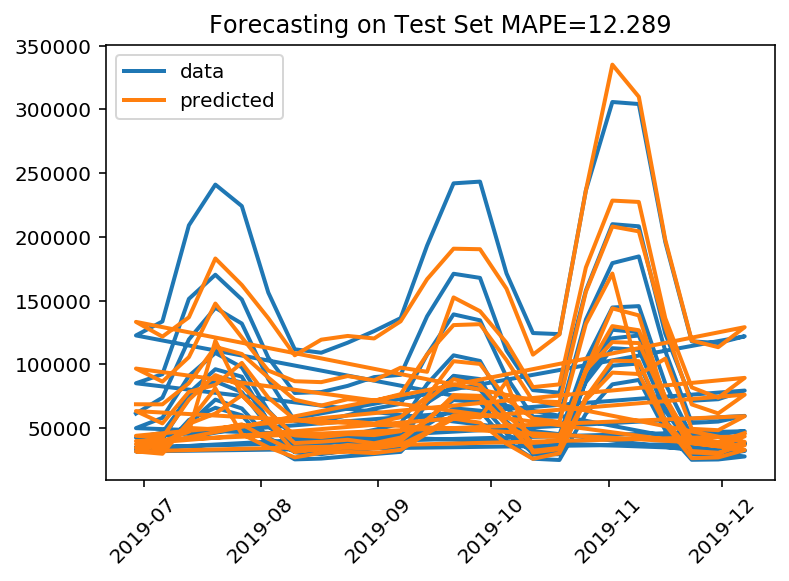

3
group_B


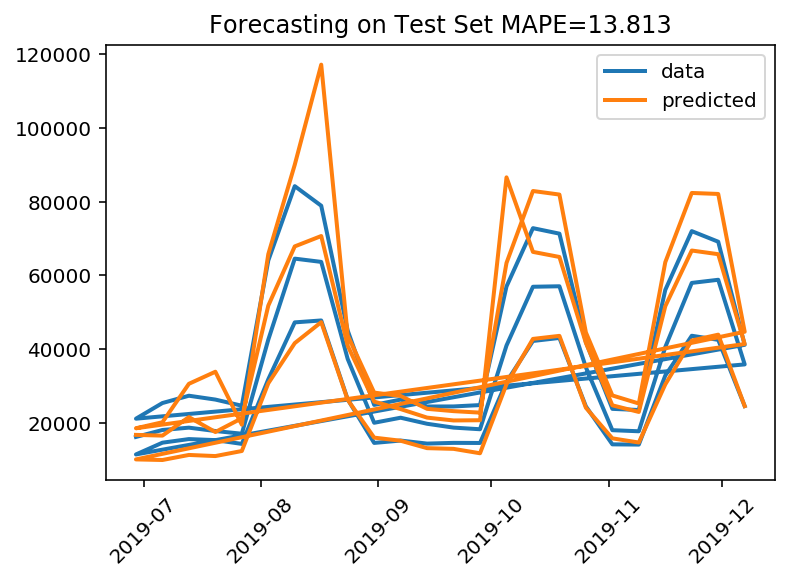

In [15]:
for g in groups:
    if g == "Not_grouped":
        continue
    y_traing = y_train.loc[X_train[g]]
    X_traing = X_train.loc[X_train[g]].drop(columns = groups)
    y_testg = y_test.loc[X_test[g]]
    X_testg = X_test.loc[X_test[g]].drop(columns = groups)
    
    
    sku_dummies = pd.get_dummies(y_traing["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_traing.index)
    X_traing = pd.concat([sku_dummies_df,X_traing],axis = 1)

    sku_dummies = pd.get_dummies(y_testg["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_testg.index)
    X_testg = pd.concat([sku_dummies_df,X_testg],axis = 1)

    
    
    model = ExtraTreesRegressor(n_estimators=100)
    
    #xgb.XGBRegressor(n_estimators=500, learning_rate=0.1) #MAPE 13.3, 16.2
    #ExtraTreesRegressor(n_estimators=100) #MAPE 11.7 13.5
    #RandomForestRegressor(n_estimators=200) #MAPE 12.9 14.6

    
    model.fit(X_traing, y_traing["scaled_target"])

    prediction = model.predict(X_testg)

    results = pd.DataFrame(columns = ["date","sku","target","prediction"])

    for sku in y_testg["sku"].unique():

        pred_sku = prediction[np.where(y_testg["sku"] == sku)]
        originals = rescale_df.loc[rescale_df["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals)

        results = pd.concat([results, pd.DataFrame({
            "date" : y_testg[y_testg["sku"] == sku]["date"],
            "sku" : y_testg[y_testg["sku"] == sku]["sku"],
            "target" : y_testg[y_testg["sku"] == sku]["target"],
            "prediction" : pred
        })])
    print(len(y_testg["sku"].unique()))

    print(g)
    results = results.dropna().set_index("date")

    plot_results(results["target"], results["prediction"], "target")


### COMPUTE PREDICTIONS WITH THE COMPLETE DATAFRAME 

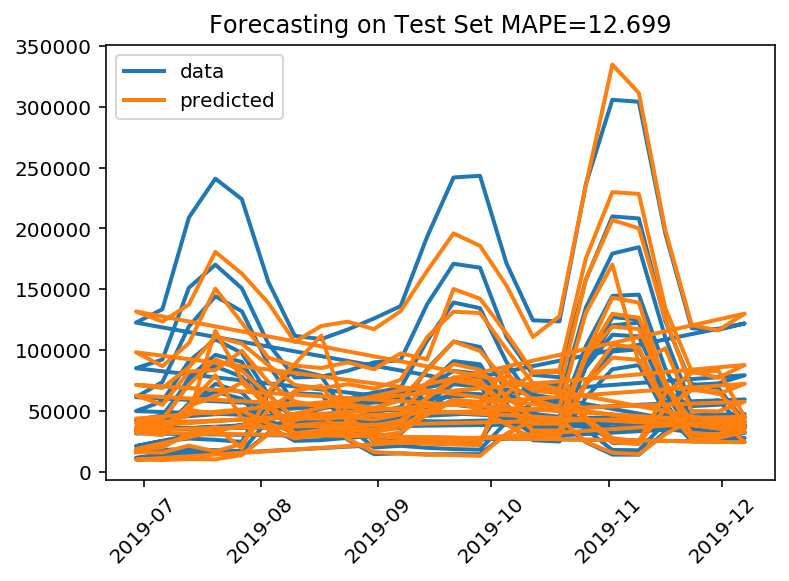

12.699410421188967

In [16]:
y_traing = y_train
X_traing = X_train
y_testg = y_test
X_testg = X_test

sku_dummies = pd.get_dummies(y_traing["sku"]) > 0
sku_dummies_df = pd.DataFrame(sku_dummies, index = X_traing.index)
X_traing = pd.concat([sku_dummies_df,X_traing],axis = 1)

sku_dummies = pd.get_dummies(y_testg["sku"]) > 0
sku_dummies_df = pd.DataFrame(sku_dummies, index = X_testg.index)
X_testg = pd.concat([sku_dummies_df,X_testg],axis = 1)

model = ExtraTreesRegressor(n_estimators=100)

#xgb.XGBRegressor(n_estimators=500, learning_rate=0.06) #MAPE 14.0
#ExtraTreesRegressor(n_estimators=100) #MAPE 12.6
#RandomForestRegressor(n_estimators=100) #MAPE 13.4

model.fit(X_traing, y_traing["scaled_target"])

prediction = model.predict(X_testg)

results = pd.DataFrame(columns = ["date","sku","target","prediction"])

for sku in y_testg["sku"].unique():

    pred_sku = prediction[np.where(y_testg["sku"] == sku)]
    originals = rescale_df.loc[rescale_df["sku"] == sku]["target"]
    pred = unscale(pred_sku,originals)

    results = pd.concat([results, pd.DataFrame({
        "date" : y_testg[y_testg["sku"] == sku]["date"],
        "sku" : y_testg[y_testg["sku"] == sku]["sku"],
        "target" : y_testg[y_testg["sku"] == sku]["target"],
        "prediction" : pred
    })])

results = results.dropna().set_index("date")

plot_results(results["target"], results["prediction"], "target")

### COMPUTE PREDICTIONS WEEK BY WEEK

In [17]:
def predict_Week(model, X_train, y_train, X_test, y_test, verbose = False):
    y_traing = y_train
    X_traing = X_train
    sku_dummies = pd.get_dummies(y_traing["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_traing.index)
    X_traing = pd.concat([sku_dummies_df,X_traing],axis = 1)

    result = []
    tot_mape = 0
    nw = 0
    for week in y_test.date.unique():

        nw = nw + 1
        if verbose:
            print(np.datetime_as_string(week, unit='D'))        
        X_testg = X_test.loc[y_test.date == week]
        y_testg = y_test.loc[y_test.date == week]



        sku_dummies = pd.get_dummies(y_testg["sku"]) > 0
        sku_dummies_df = pd.DataFrame(sku_dummies, index = X_testg.index)
        X_testg = pd.concat([sku_dummies_df,X_testg],axis = 1)

        model.fit(X_traing, y_traing["scaled_target"])

        week_pred = model.predict(X_testg)



        unscale_pred = []
        for sku in y_testg["sku"]:
            pred_sku = week_pred[np.where(y_testg["sku"] == sku)]
            originals = rescale_df.loc[rescale_df["sku"] == sku]["target"]
            pred = unscale(pred_sku,originals) 
            unscale_pred = np.append(unscale_pred,pred) 


        result = np.append(result,unscale_pred)


        week_mape = mean_absolute_percentage_error(y_testg.target, unscale_pred)
        tot_mape = tot_mape + week_mape
        if verbose:
            print("MAPE: %.5f \n" % (tot_mape/nw))


        X_traing = pd.concat([X_traing,X_testg])
        y_traing = pd.concat([y_traing,y_testg])


    return tot_mape/nw, result   

In [18]:
xgb_reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1) 
xgb_mape, xgb_pred = predict_Week(xgb_reg, X_train, y_train, X_test, y_test, verbose = False)
extra_reg = ExtraTreesRegressor(n_estimators=500) 
extra_mape, extra_pred = predict_Week(extra_reg, X_train, y_train, X_test, y_test, verbose = False)
forest_reg = RandomForestRegressor(n_estimators=100) 
forest_mape, forest_pred = predict_Week(forest_reg, X_train, y_train, X_test, y_test, verbose = False)

In [19]:
print("XGB MAPE: %.5f \n" % (xgb_mape))
print("FOREST MAPE: %.5f \n" % (forest_mape))
print("EXTRA MAPE: %.5f \n" % (extra_mape))


XGB MAPE: 10.41891 

FOREST MAPE: 10.59336 

EXTRA MAPE: 9.73299 



AVARAGE PREDICTIONS:

In [20]:
final_prediction = 0.3 * forest_pred + 0.3 * xgb_pred + 0.4 *  extra_pred

mape = mean_absolute_percentage_error(y_test.target, final_prediction)
mape

9.659513084535472

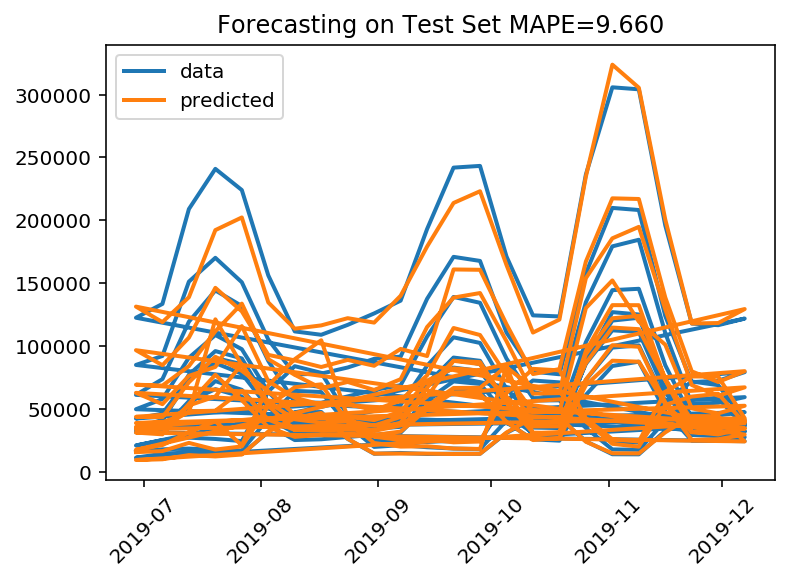

(9.659513084535472,
              sku    target    prediction  scaled_target  scaled_prediction
 date                                                                      
 2019-06-29   144   16228.0  1.890230e+09       0.063781       15915.646393
 2019-07-06   144   18114.0  1.987487e+09       0.079662       16734.549098
 2019-07-13   144   18748.0  2.761432e+09       0.085000       23251.156974
 2019-07-20   144   17833.0  2.128877e+09       0.077295       17925.046737
 2019-07-27   144   17105.0  2.428299e+09       0.071166       20446.180355
 ...          ...       ...           ...            ...                ...
 2019-11-09  1206  111353.0  1.326149e+10       0.711474      113593.378961
 2019-11-16  1206   63359.0  8.543074e+09       0.300373       73176.976047
 2019-11-23  1206   35238.0  4.820878e+09       0.059497       41293.845795
 2019-11-30  1206   34242.0  4.403184e+09       0.050966       37716.014020
 2019-12-07  1206   37889.0  4.742810e+09       0.082205       40625

In [21]:
plot_scaled_results(final_prediction, y_test, rescale_df)


In [22]:
sku_dummies = pd.get_dummies(y_train["sku"]) > 0
sku_dummies_df = pd.DataFrame(sku_dummies, index = X_train.index)
X_traing = pd.concat([sku_dummies_df,X_train],axis = 1)

sku_dummies = pd.get_dummies(y_test["sku"]) > 0
sku_dummies_df = pd.DataFrame(sku_dummies, index = X_test.index)
X_testg = pd.concat([sku_dummies_df,X_test],axis = 1)

X = pd.concat([X_traing,X_testg])

In [23]:
X = X.iloc[:-12]

In [24]:
shap_tree = shap.TreeExplainer(forest_reg)

In [25]:
shap_values = shap_tree.shap_values(X)

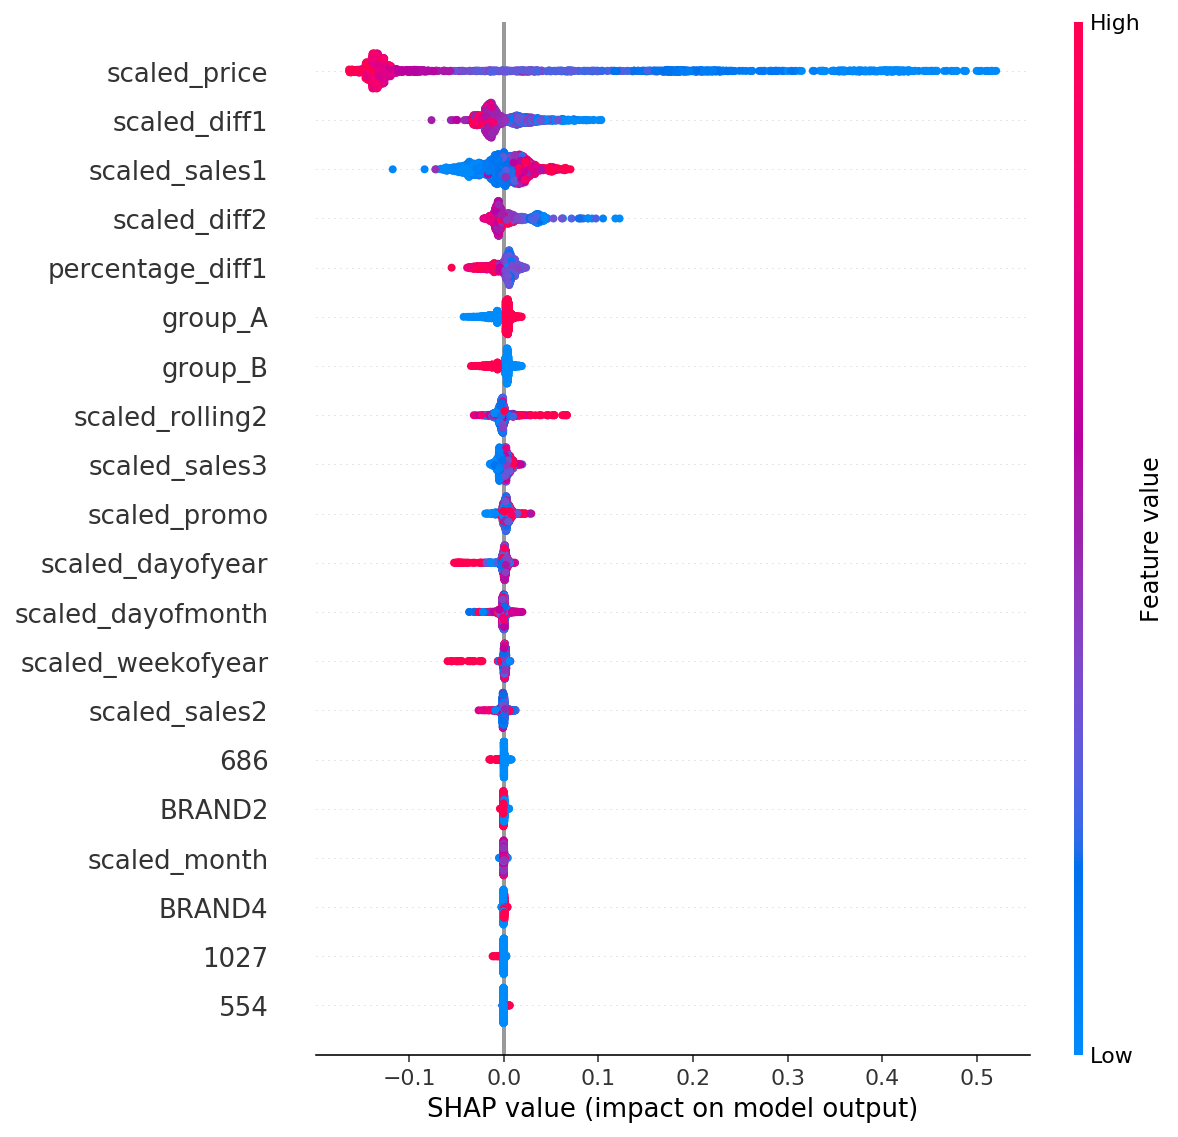

In [26]:
shap.summary_plot(shap_values, X)